This demo is about curve-fitting in general. 

In [7]:
# These are just utility functions to set things up

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
rng = default_rng()

# Let's start with a linear model. y = mx+b
def myline(x, m, b):
    return m*x+b

# This helper fuction plots data against the true model and against the fit model
def myplot(*args): # (x, y_data, y_truth, y_model)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    x = args[0]
    y_data = args[1]
    ax.plot(x, y_data, 'ko', label='data')
    if len(args) > 2:
        y_truth = args[2]
        ax.plot(x, y_truth, 'r-', label='truth')
    if len(args) > 3:
        y_model = args[3]
        ax.plot(x, y_model, 'b-', label='model')
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_title('x vs y')
    legend = ax.legend(loc='upper left', fontsize='x-large')

First we are going to generate some data points along a straight line of slope 3 and y-intecept 2. Then we are going to sprinkle some random jitter onto it, and plot both.

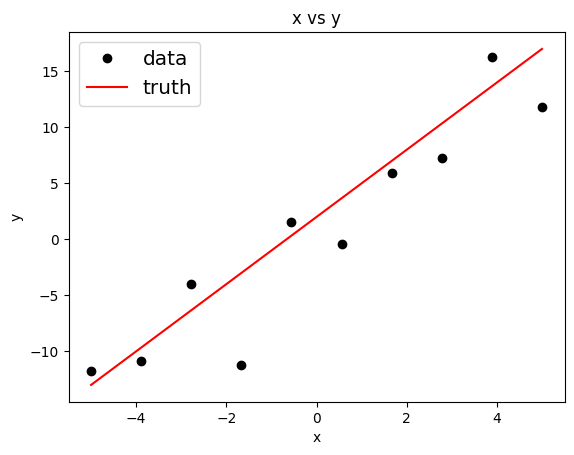

In [8]:
m = 3.0
b = 2.0                                                                                                                                                                 
x = np.linspace(-5,5,10)
y_truth = myline(x, m, b)
y_data = y_truth + rng.normal(0,5,len(x))

# Plot data vs theory                                                                                                                                                              
myplot(x, y_data, y_truth)

Recall that we can calculate the root mean square error RMSE in order to estimate the goodness-of-fit (i.e. how large the residuals are overall):

In [4]:
np.mean( ( y_data - myline(x,m,b) ) ** 2 ) ** 0.5

7.071205535426793

A related quantity is called the chi-squared, which is the sum of the residuals squared:

In [5]:
np.sum( ( ( y_data - myline(x,m,b) ) ) ** 2 )

500.01947724250516

The RMSE is just the sqrt( chi2 / N ):

In [6]:
( np.sum( ( y_data - myline(x,m,b) ) ** 2 ) / len(y_data) ) ** 0.5

7.071205535426793

Recall that the best fit of a model to data is the one that minimizes the RMSE. Since the chi2 just differs by an overall sqrt and constant factor, the best fit equivalently minimizes chi2. Since chi2 minimization is common in the real world, I'll use it here so you can get used to the terminology.

Next we are going to loop through various possible slope/intercept fit models and find the one with the lowest chi2. Then plot model against the data and the true model. 

best fit chi2 =  109.19 , for m =  2.79  and b =  0.43


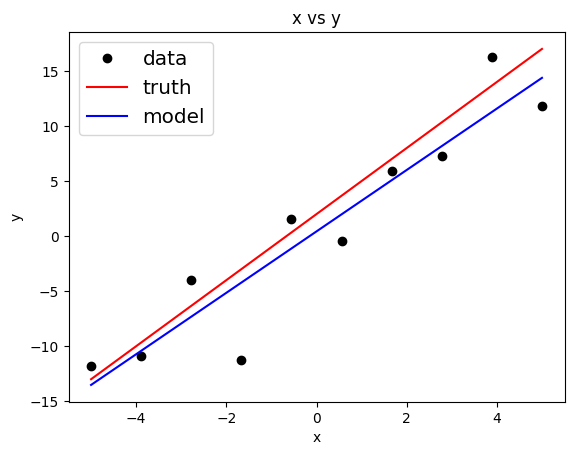

In [9]:
# Find best fit for range of possible m, b
least_chi2 = float('inf') 
for m in np.linspace(-5,5,200):
    for b in np.linspace(-5,5,200):
        chi2 = np.sum( ( y_data - myline(x,m,b) ) ** 2 )
        if chi2 < least_chi2:
            least_chi2 = chi2
            m_best_fit = m
            b_best_fit = b
    
print('best fit chi2 = ', np.round(least_chi2,2), ', for m = ', np.round(m_best_fit,2), ' and b = ', np.round(b_best_fit,2))

# best fit theory                                                                                                                                                                   
y_best_fit = myline(x, m_best_fit, b_best_fit) #m*x+b
# Plot data vs theory
myplot(x, y_data, y_truth, y_best_fit)

Notice that finding the parameters that reduced the chi2 was computationally difficult: we blindly considered all possible parameters in a range and by brute force found those that minimized chi2. Is there a better way? Let's first map out chi2 as a function of the parameters m & b:

Text(0, 0.5, 'b')

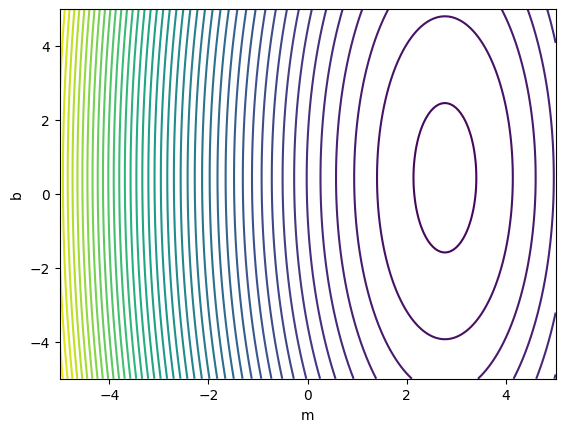

In [10]:
# Instead of finding the lowest chi2, let's just calculate it for every point in our grid:
mlist = np.linspace(-5,5,200)
blist = np.linspace(-5,5,200)
chi2_2D, _ = np.meshgrid(mlist, blist)
for i in range(len(mlist)):
    for j in range(len(blist)):
        chi2_2D[j,i] = np.sum( ( ( y_data - myline(x,mlist[i],blist[j]) ) ) ** 2 )

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.contour(mlist,blist,chi2_2D,50)
ax.set_xlabel('m')
ax.set_ylabel('b')

Notice that we see contour lines of a nice 2D function here. If you remember a bit of vector calculus, you may recall that the gradient of a function points along the direction of maximum derivative, and points orthogonal to contour lines. In other words, by finding the gradient of the shape in m-b space in some smaller region, we can figure out which way to move in m-b space in order to move towards minimum chi2. This would allow us to not have to sample the entire space via the brute force method above. Such a method is called Gradient Descent. Let's implement it!

The gradient of a function F is the vector (dF/dx, dF/dy, ...). In our case F is the chi2, and our dimensions are m and b, so the gradient is (dF/dm, dF/db). So we need some starting point (m,b) and move a bit by (dm,db) in some direction, and calculate the gradient, and it will point us away from the way we want to move. In our case let's start at (0,0) and let (dm,db) be based on what they were in our mesh above:

In [11]:
mlist[1]-mlist[0]

0.05025125628140703

OK so we will let dm = db = 0.05, and we will initially move in the positive m,b direction, to see where to go next, choosing somewhat arbitrarily a stepsize for how much to move in m,b space as a scale factor of the gradient.

In [12]:
m = b = 0
dm = db = 0.05
stepsize = 0.01
grad_m = np.sum( ( ( y_data - myline(x,m+dm,b) ) ) ** 2 ) - np.sum( ( ( y_data - myline(x,m,b) ) ) ** 2 )
grad_b = np.sum( ( ( y_data - myline(x,m,b+db) ) ) ** 2 ) - np.sum( ( ( y_data - myline(x,m,b) ) ) ** 2 )
new_m = m - stepsize * grad_m
new_b = b - stepsize * grad_b
print(new_m, new_b)

0.2793098861921749 0.004121112286265998


We seem to be going in the right direction! Next we just need to continue this process, and have some criteria for when to stop. We can keep track of the chi2, and if it ever increases, we know we've gone too far (although we can later discuss local minima!) Below I will plot our results against the contour plot we found earlier:

best fit chi2 =  109.2 , for m =  2.74  and b =  0.44


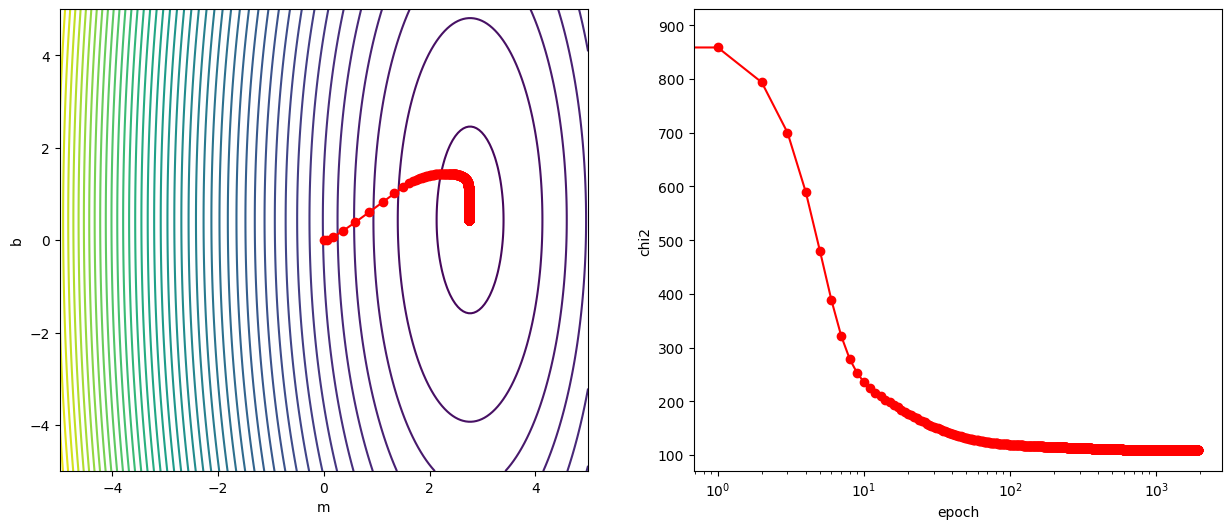

In [15]:
m = b = 0
dm = db = 0.05
stepsize = 0.002
newchi2 = np.sum( ( ( y_data - myline(x,m,b) ) ) ** 2 )
chi2 = newchi2 + 1
epoch = 0
m_list = []
b_list = []
chi2_list = [ newchi2 ]
epoch_list = [ epoch ]
while(newchi2 < chi2):
    epoch += 1
    m_list.append(m)
    b_list.append(b)
    grad_m = np.sum( ( ( y_data - myline(x,m+dm,b) ) ) ** 2 ) - chi2
    grad_b = np.sum( ( ( y_data - myline(x,m,b+db) ) ) ** 2 ) - chi2
    m = m - stepsize * grad_m
    b = b - stepsize * grad_b
    chi2 = newchi2
    newchi2 = np.sum( ( ( y_data - myline(x,m,b) ) ) ** 2 )
    chi2_list.append( newchi2 )
    epoch_list.append( epoch )

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
ax[0].contour(mlist,blist,chi2_2D,50)
ax[0].plot(m_list,b_list, 'ro-')
ax[0].set_xlabel('m')
ax[0].set_ylabel('b')

ax[1].plot(epoch_list, chi2_list, 'ro-')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('chi2')
ax[1].set_xscale('log')
#ax[1].set_yscale('log')

print('best fit chi2 = ', np.round(chi2,2), ', for m = ', np.round(m,2), ' and b = ', np.round(b,2))

Next we are going to use a vetted curve fit function from SciPy to do all of this, rather than doing it ourself.

Fit m:  2.77  +-  0.37
Fit b:  0.44  +-  1.17


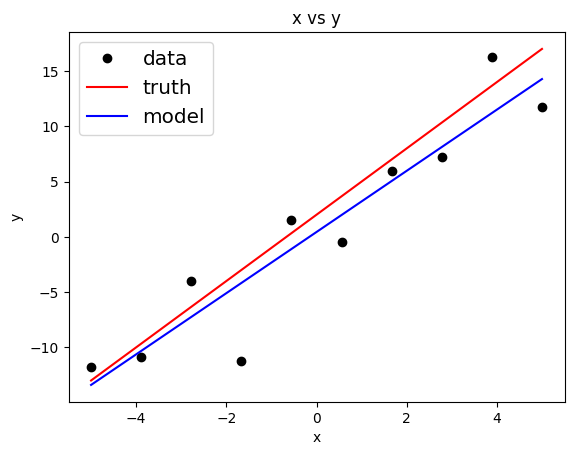

In [17]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(myline, x, y_data, p0=[0,0], bounds=([-5,-5], [5, 5]))
perr = np.sqrt(np.diag(pcov))

myplot(x, y_data, y_truth, myline(x,*popt))

print('Fit m: ', np.round(popt[0],2), ' +- ', np.round(perr[0],2) )
print('Fit b: ', np.round(popt[1],2), ' +- ', np.round(perr[1],2) )

How do the errors change if we increase the number of data points (but keep scatter level the same)?

Fit m:  2.49  +-  0.16
Fit b:  1.89  +-  0.47


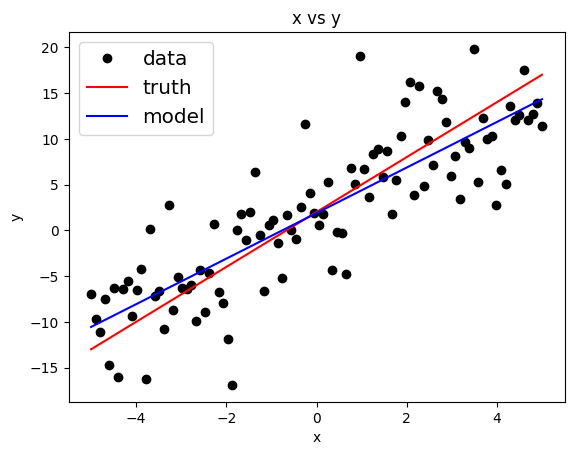

In [18]:
m = 3.0
b = 2.0      
x = np.linspace(-5,5,100)
y_truth = myline(x, m, b)
y_data = y_truth + rng.normal(0,5,len(x))

popt, pcov = curve_fit(myline, x, y_data, p0=[0,0], bounds=([-5,-5], [5, 5]))
perr = np.sqrt(np.diag(pcov))

myplot(x, y_data, y_truth, myline(x,*popt))

print('Fit m: ', np.round(popt[0],2), ' +- ', np.round(perr[0],2) )
print('Fit b: ', np.round(popt[1],2), ' +- ', np.round(perr[1],2) )

Can we trust the error bars? Let's re-run the fit 1000 times and see what fraction of the time the true value is within the given error bars.

In [21]:
m = 3.0
b = 2.0      
x = np.linspace(-5,5,100)
y_truth = myline(x, m, b)

numWithinErr_m = 0
numWithinErr_b = 0
for i in range(1000):
  y_data = y_truth + rng.normal(0,5,len(x))
  popt, pcov = curve_fit(myline, x, y_data, p0=[0,0], bounds=([-5,-5], [5, 5]))
  perr = np.sqrt(np.diag(pcov))
  if np.abs(popt[0]-m) < perr[0]:
    numWithinErr_m += 1
  if np.abs(popt[1]-b) < perr[1]:
    numWithinErr_b += 1

print('Fraction of fitted m within error: ', np.round(numWithinErr_m/1000,2))
print('Fraction of fitted b within error: ', np.round(numWithinErr_b/1000,2))

Fraction of fitted m within error:  0.68
Fraction of fitted b within error:  0.67


Note you should have seen that the true value is within the given error bars about 68% of the time. Error bars by convention represent "1-sigma" errors: defined to represent the extent to which sampled values are expected to deviate from the mean, 68% of the time. That is, 32% of the time the sampled value should be outside the error bars.

Now, in the real world we don't know what the true model is. In this case we know we started with a linear model and added noise. Let's go back to 10 data points and imagine that we didn't know the true model:

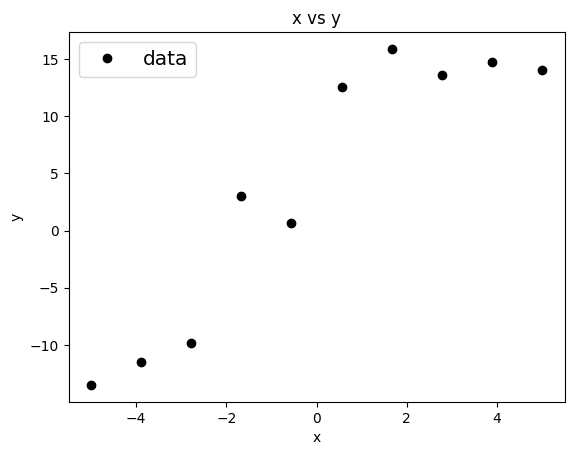

In [22]:
m = 3.0
b = 2.0      
x = np.linspace(-5,5,10)
y_truth = myline(x, m, b)
y_data = y_truth + rng.normal(0,5,len(x))

myplot(x, y_data)

For all we know, the true model could be constant (polynomial of degree 0) plus noise, or linear (degree 1), or quadratic (degree 2), or degree N. It could be a sin or cos or tan or exponential function. It could be piece-wise linear. It could be discontinuous. Here let's compare a linear model (2 degrees of freedom) fit to a polynomial of degree 3 (4 degrees of freedom): 

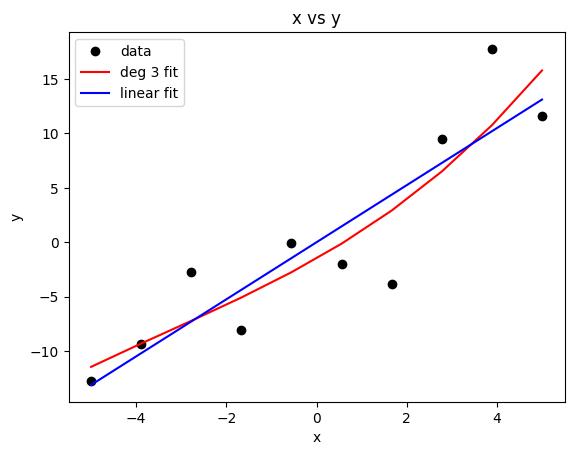

In [29]:
# Polynomial of degree 3: y = ax^3 + bx^2 + cx + d
def mypoly_deg3(x, a, b, c, d):
  return a*x**3 + b*x**2 + c*x + d
  
m = 3.0
b = 2.0      
x = np.linspace(-5,5,10)
y_truth = myline(x, m, b)
y_data = y_truth + rng.normal(0,5,len(x))

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x, y_data, 'ko', label='data')

popt, pcov = curve_fit(mypoly_deg3, x, y_data, p0=[0,0,0,0], bounds=([-5,-5,-5,-5], [5, 5, 5, 5]))
perr = np.sqrt(np.diag(pcov))
y_poly_fit = mypoly_deg3(x,*popt)
ax.plot(x, y_poly_fit, 'r-', label='deg 3 fit')

popt, pcov = curve_fit(myline, x, y_data, p0=[0,0], bounds=([-5,-5], [5, 5]))
perr = np.sqrt(np.diag(pcov))
y_linear_fit = myline(x,*popt)
ax.plot(x, y_linear_fit, 'b-', label='linear fit')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('x vs y')
ax.legend()

Since a polynomial of degree 3 includes a linear model as a subset (just set a = b = 0 above), you might think it is a better model to use. Indeed, the fit is "better" at getting closer to the data points. Let's calculate the chi2 for each:

In [30]:
from scipy.stats import chisquare

print("chi2 for linear model: ", np.round(np.sum((y_linear_fit - y_data) ** 2),2))
print("chi2 for poly 3 model: ", np.round(np.sum((y_poly_fit - y_data) ** 2),2))

chi2 for linear model:  181.21
chi2 for poly 3 model:  162.8


In fact, it turns out that you can fit the 10 data points "perfectly" with a polynomial of degree 9, since there are 10 degrees of freedom:

chi2 for linear model:  151.71
chi2 for poly 3 model:  0.0


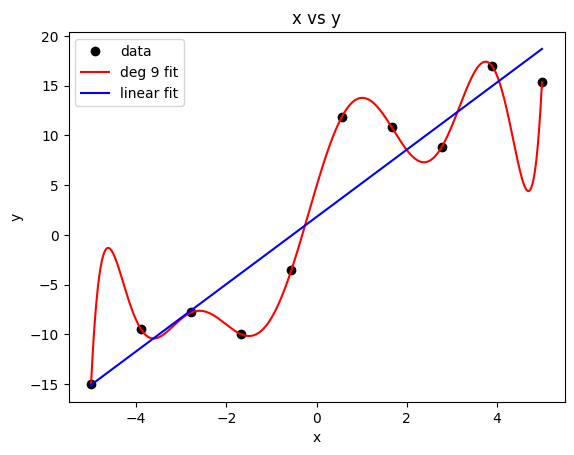

In [31]:
m = 3.0
b = 2.0      
x = np.linspace(-5,5,10)
y_truth = myline(x, m, b)
y_data = y_truth + rng.normal(0,5,len(x))

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x, y_data, 'ko', label='data')

z = np.polyfit(x, y_data, 9)
p = np.poly1d(z)
x_granular = np.linspace(x[0],x[-1],100*len(x))
y_poly_fit = p(x)
y_poly_fit_for_plotting = p(x_granular)
ax.plot(x_granular, y_poly_fit_for_plotting, 'r-', label='deg 9 fit')

popt, pcov = curve_fit(myline, x, y_data, p0=[0,0], bounds=([-5,-5], [5, 5]))
perr = np.sqrt(np.diag(pcov))
y_linear_fit = myline(x,*popt)
ax.plot(x, y_linear_fit, 'b-', label='linear fit')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('x vs y')
ax.legend()

print("chi2 for linear model: ", np.round(np.sum((y_linear_fit - y_data) ** 2),2))
print("chi2 for poly 3 model: ", np.round(np.sum((y_poly_fit - y_data) ** 2),2))

This is called "over-fitting". As a rule fo thumb, in the absence of a compelling reason to choose a particular model, it is reasonable to make sure you have at least 10 data points per degree of freedom of your model. So in this case a polynomial of degree 9 (10 d.o.f) would be reasonable to choose if we had 100 data points rather than 10: 

chi2 for linear model:  2573.73
chi2 for poly 3 model:  2432.59


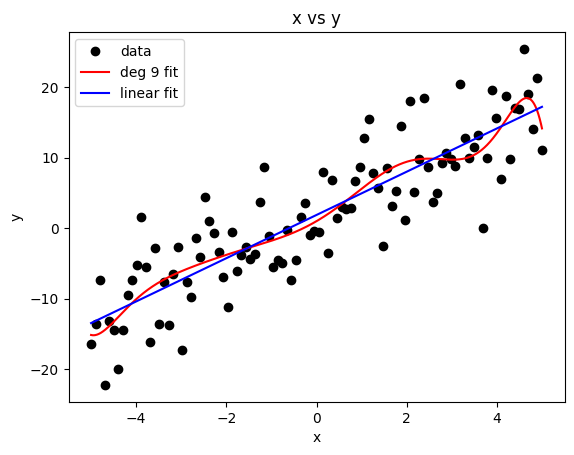

In [32]:
m = 3.0
b = 2.0      
x = np.linspace(-5,5,100)
y_truth = myline(x, m, b)
y_data = y_truth + rng.normal(0,5,len(x))

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x, y_data, 'ko', label='data')

z = np.polyfit(x, y_data, 9)
p = np.poly1d(z)
x_granular = np.linspace(x[0],x[-1],100*len(x))
y_poly_fit = p(x)
y_poly_fit_for_plotting = p(x_granular)
ax.plot(x_granular, y_poly_fit_for_plotting, 'r-', label='deg 9 fit')

popt, pcov = curve_fit(myline, x, y_data, p0=[0,0], bounds=([-5,-5], [5, 5]))
perr = np.sqrt(np.diag(pcov))
y_linear_fit = myline(x,*popt)
ax.plot(x, y_linear_fit, 'b-', label='linear fit')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('x vs y')
ax.legend()

print("chi2 for linear model: ", np.round(np.sum((y_linear_fit - y_data) ** 2),2))
print("chi2 for poly 3 model: ", np.round(np.sum((y_poly_fit - y_data) ** 2),2))

Here you see in this case the linear and polynomial models give similar chi2 results. In this case since we know the true model is a linear model, and the polynomial model gives a slightly better chi2, we know our polynomial model is slightly over-fitting the data. To account for the number of d.o.f. in the data, the reduced chi2 can be calculated, by dividing the chi2 by the (#data points - fit d.o.f.):

In [33]:
print("chi2 for linear model: ", np.sum((y_linear_fit - y_data) ** 2)/(len(y_data)-2))
print("chi2 for poly 9 model: ", np.sum((y_poly_fit - y_data) ** 2)/(len(y_data)-10))

chi2 for linear model:  26.262598764077968
chi2 for poly 9 model:  27.028823854076695


And finally you see the reduced chi2 are nearly identical, with the linear model slightly better, as we would expect! (Note the reduced chi2 is similar to the Mean Square Error, but instead of dividing by N we are dividing by (N - k), where k is the number of d.o.f. of the fit)

Is there a better way of checking whether we are over fitting? Yes! We divide our data into two independent sets: one to do the fit (the "training" set), and the other to check the goodness of fit on novel data. In other words: one dataset forms a prediction, the second tests that prediction. If the data is over-fit, the prediction won't fare well when tested. Let's try. First here is the data we want to fit:

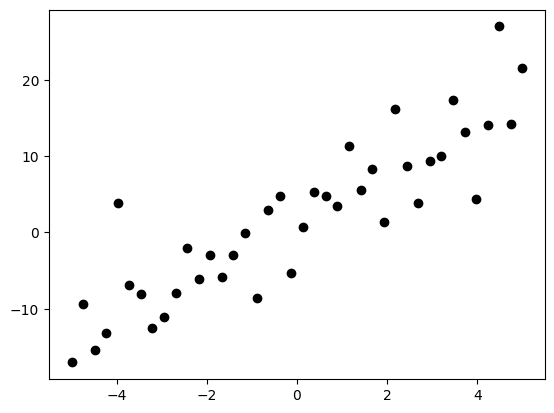

In [63]:
m = 3.0
b = 2.0      
x = np.linspace(-5,5,40)
y_truth = myline(x, m, b)
y_data = y_truth + rng.normal(0,5,len(x))

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x, y_data, 'ko', label='data')

Next let's divide the data into two independent sets:

(-19.050858574593605, 28.985917901402303)

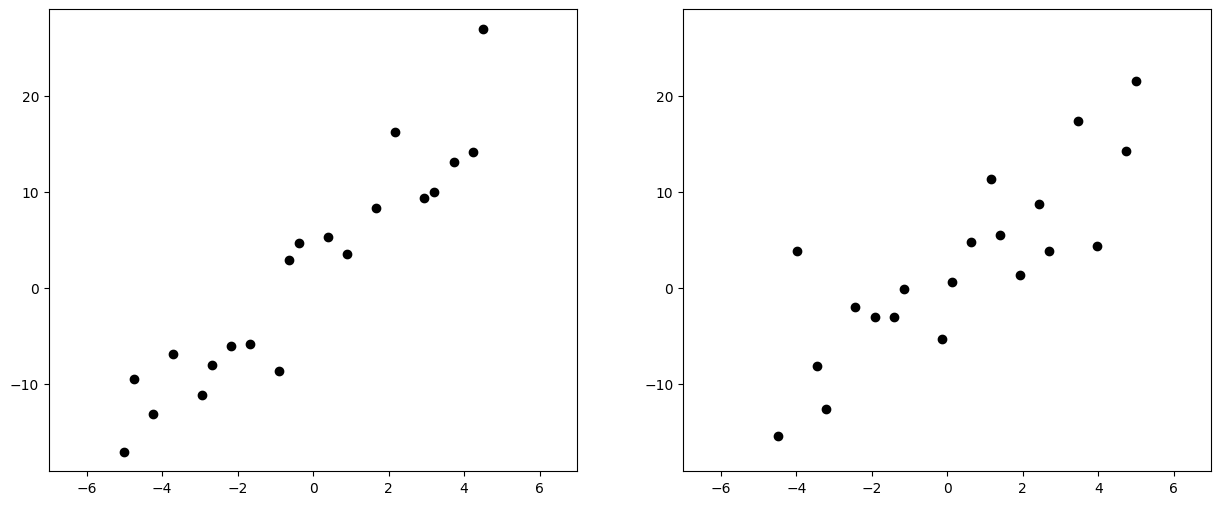

In [64]:
indices_training = np.sort(np.random.choice(len(x), int(len(x)/2), replace=False))
indices_testing = np.delete(np.arange(len(x)), indices_training)

x_full = x
y_full_data = y_data

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

x = x_full[indices_training]
y_data = y_full_data[indices_training]
ax[0].plot(x, y_data, 'ko', label='data training')
ax[0].set_xlim([np.min(x_full)-2, np.max(x_full)+2])
ax[0].set_ylim([np.min(y_full_data)-2, np.max(y_full_data)+2])

x = x_full[indices_testing]
y_data = y_full_data[indices_testing]
ax[1].plot(x, y_data, 'ko', label='data testing')
ax[1].set_xlim([np.min(x_full)-2, np.max(x_full)+2])
ax[1].set_ylim([np.min(y_full_data)-2, np.max(y_full_data)+2])

Now let's do our linear and poly 9 fits on the first dataset, and test it on the second

chi2 for linear model (training):  16.93519329020995
chi2 for poly 9 model (training):  16.228342991786263
chi2 for linear model (testing):  37.81546729406759
chi2 for poly 9 model (testing):  708.9401234332252


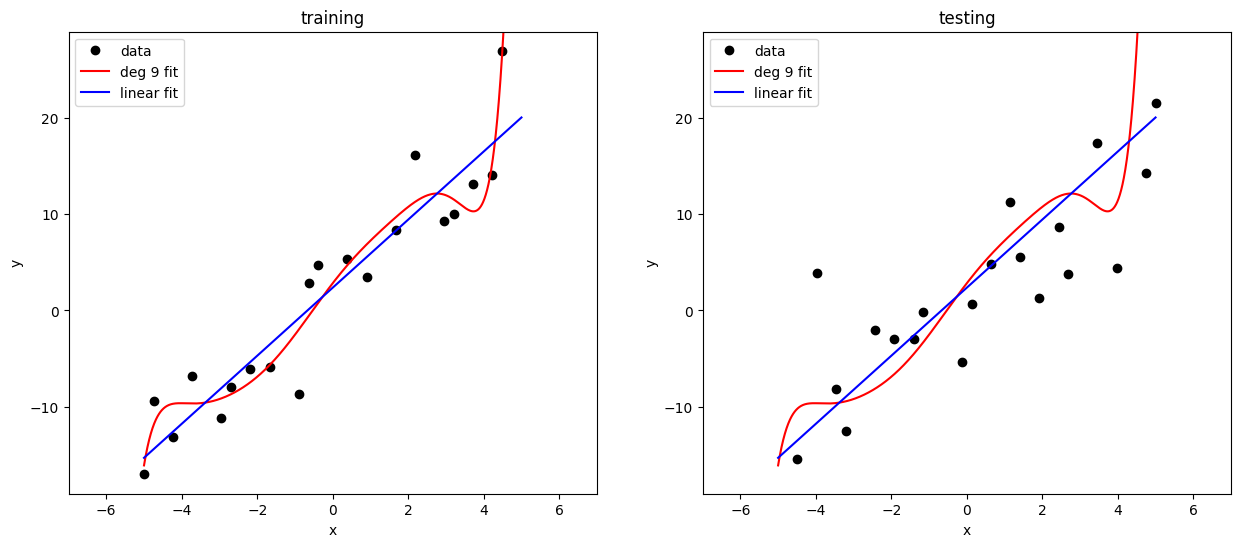

In [65]:
# First the training phase

x = x_full[indices_training]
y_data = y_full_data[indices_training]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
ax[0].plot(x, y_data, 'ko', label='data')

z = np.polyfit(x, y_data, 9)
p = np.poly1d(z)
y_poly_fit = p(x)
x_granular = np.linspace(x_full[0],x_full[-1],100*len(x))
y_poly_fit_for_plotting = p(x_granular)
ax[0].plot(x_granular, y_poly_fit_for_plotting, 'r-', label='deg 9 fit')

popt, pcov = curve_fit(myline, x, y_data, p0=[0,0], bounds=([-5,-5], [5, 5]))
perr = np.sqrt(np.diag(pcov))
y_linear_fit = myline(x,*popt)
y_linear_fit_for_plotting = myline(x_granular,*popt)
ax[0].plot(x_granular, y_linear_fit_for_plotting, 'b-', label='linear fit')

ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('training')
ax[0].set_xlim([np.min(x_full)-2, np.max(x_full)+2])
ax[0].set_ylim([np.min(y_full_data)-2, np.max(y_full_data)+2])
ax[0].legend()

print("chi2 for linear model (training): ", np.sum((y_linear_fit - y_data) ** 2)/(len(y_data)-2))
print("chi2 for poly 9 model (training): ", np.sum((y_poly_fit - y_data) ** 2)/(len(y_data)-10))

# Now the testing phase
x = x_full[indices_testing]
y_data = y_full_data[indices_testing]

ax[1].plot(x, y_data, 'ko', label='data')

y_poly_fit = p(x) # using previous fit
ax[1].plot(x_granular, y_poly_fit_for_plotting, 'r-', label='deg 9 fit')

y_linear_fit = myline(x,*popt)
ax[1].plot(x_granular, y_linear_fit_for_plotting, 'b-', label='linear fit')

ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('testing')
ax[1].set_xlim([np.min(x_full)-2, np.max(x_full)+2])
ax[1].set_ylim([np.min(y_full_data)-2, np.max(y_full_data)+2])
ax[1].legend()

print("chi2 for linear model (testing): ", np.sum((y_linear_fit - y_data) ** 2)/(len(y_data)-2))
print("chi2 for poly 9 model (testing): ", np.sum((y_poly_fit - y_data) ** 2)/(len(y_data)-10))

Above you see that in training the poly 9 fit did as well as linear, but in testing, the linear fit was indeed the better match to the data, since the rule-of-thumb (10+ data points per degree of freedom) tells us that for 20 data points, 2 d.o.f. (a linear fit) is the most we should use. 